In "Adding predictors to our model" lesson, Alex proposes building the pooled version of the regression on fish data using all predictors.
This notebook contains an implementation of such model.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings
from IPython.display import Image

In [2]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8296
np.random.seed(RANDOM_SEED)

In [3]:
fish_market = pd.read_csv("data/fish-market.csv")
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")

fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)

fish_reduced = fish_market[fish_market["Weight"] != 0].copy()

/home/oriol/bin/miniforge3/envs/intuitive_bayes/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Previous cells are just importing the data and formating it so we have equivalent of a state from the lesson where we coded fish_simple model.

Below you can find a solution to the task of making pooled model, with one slope per parameter which are shared between all species.

In [4]:
COORDS = {
    "slopes": ["width_effect", "height_effect", "length_effect"]
}
with pm.Model(coords= COORDS) as fish_simple:
    #data
    log_width = pm.ConstantData("log_width", fish_reduced.log_width.values)
    log_height = pm.ConstantData("log_height", fish_reduced.log_height.values)
    log_length = pm.ConstantData("log_length", fish_reduced.log_length.values)
    log_weight = pm.ConstantData("log_weight", fish_reduced.log_weight.values)
    
    #prior
    intercept = pm.Normal("intercept", sigma = 1.0)
    β = pm.Normal("β", sigma=0.5, dims=("slopes"))
    
    sigma = pm.HalfNormal("eps", 1.0)
    
    #linear regression
    mu = (
        intercept
        + β[0] * log_width
        + β[1] * log_height
        + β[2] * log_length
    )
    
    pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

Let's visualize the model:

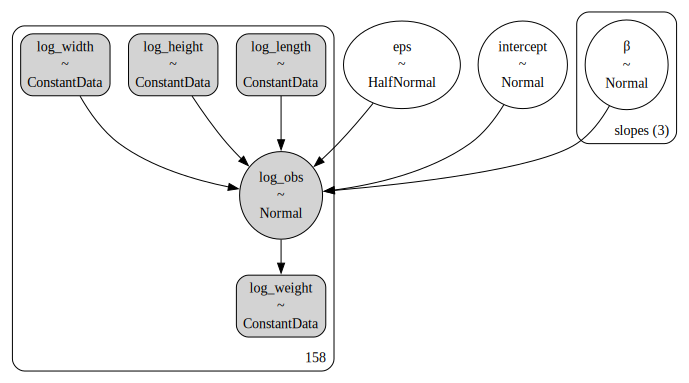

In [5]:
pm.model_to_graphviz(fish_simple)

In [6]:
with fish_simple:
    idata_simple = pm.sample(random_seed=RANDOM_SEED,target_accept=0.95)
    idata_simple.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata_simple.extend(pm.sample_posterior_predictive(idata_simple, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
Sampling: [eps, intercept, log_obs, β]
Sampling: [log_obs]


Cells below are exactly the same as in the lesson, allowing us to see the effect of pooling our data in the model

In [7]:
az.summary(idata_simple, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.73,0.11,-1.95,-1.52,0.0,0.0,1243.67,1573.51,1.01
β[width_effect],0.96,0.06,0.85,1.08,0.0,0.0,1302.07,1746.34,1.01
β[height_effect],0.63,0.03,0.57,0.69,0.0,0.0,1820.58,2033.91,1.00
β[length_effect],1.41,0.05,1.32,1.51,0.0,0.0,1280.38,1596.40,1.01
eps,0.10,0.01,0.09,0.11,0.0,0.0,2565.87,2260.36,1.00


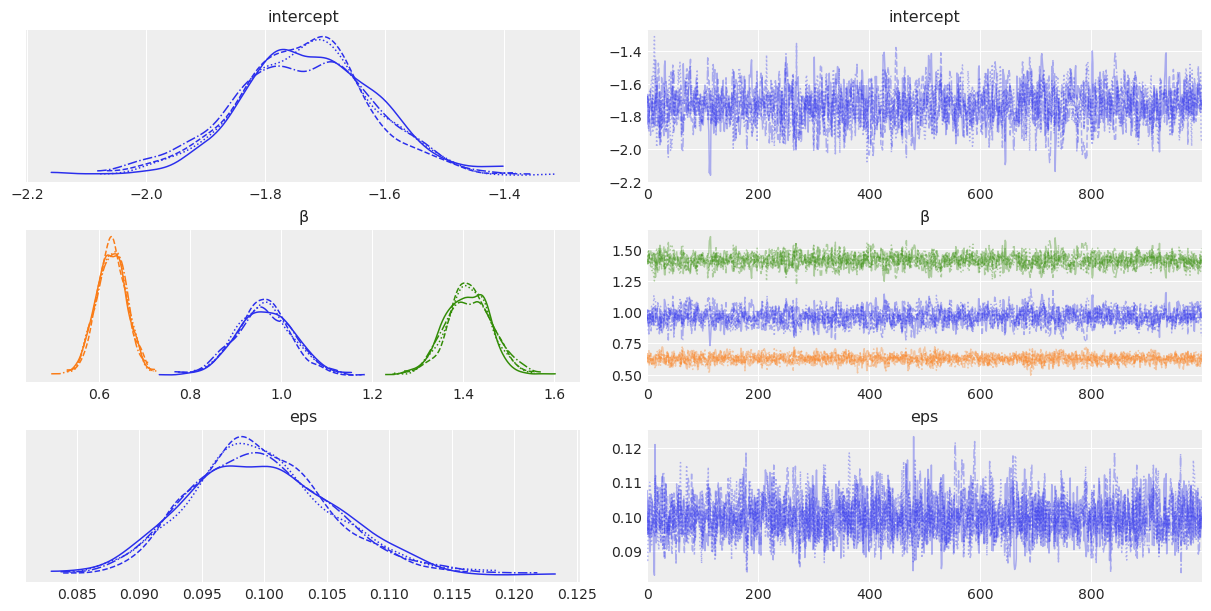

In [8]:
az.plot_trace(idata_simple);

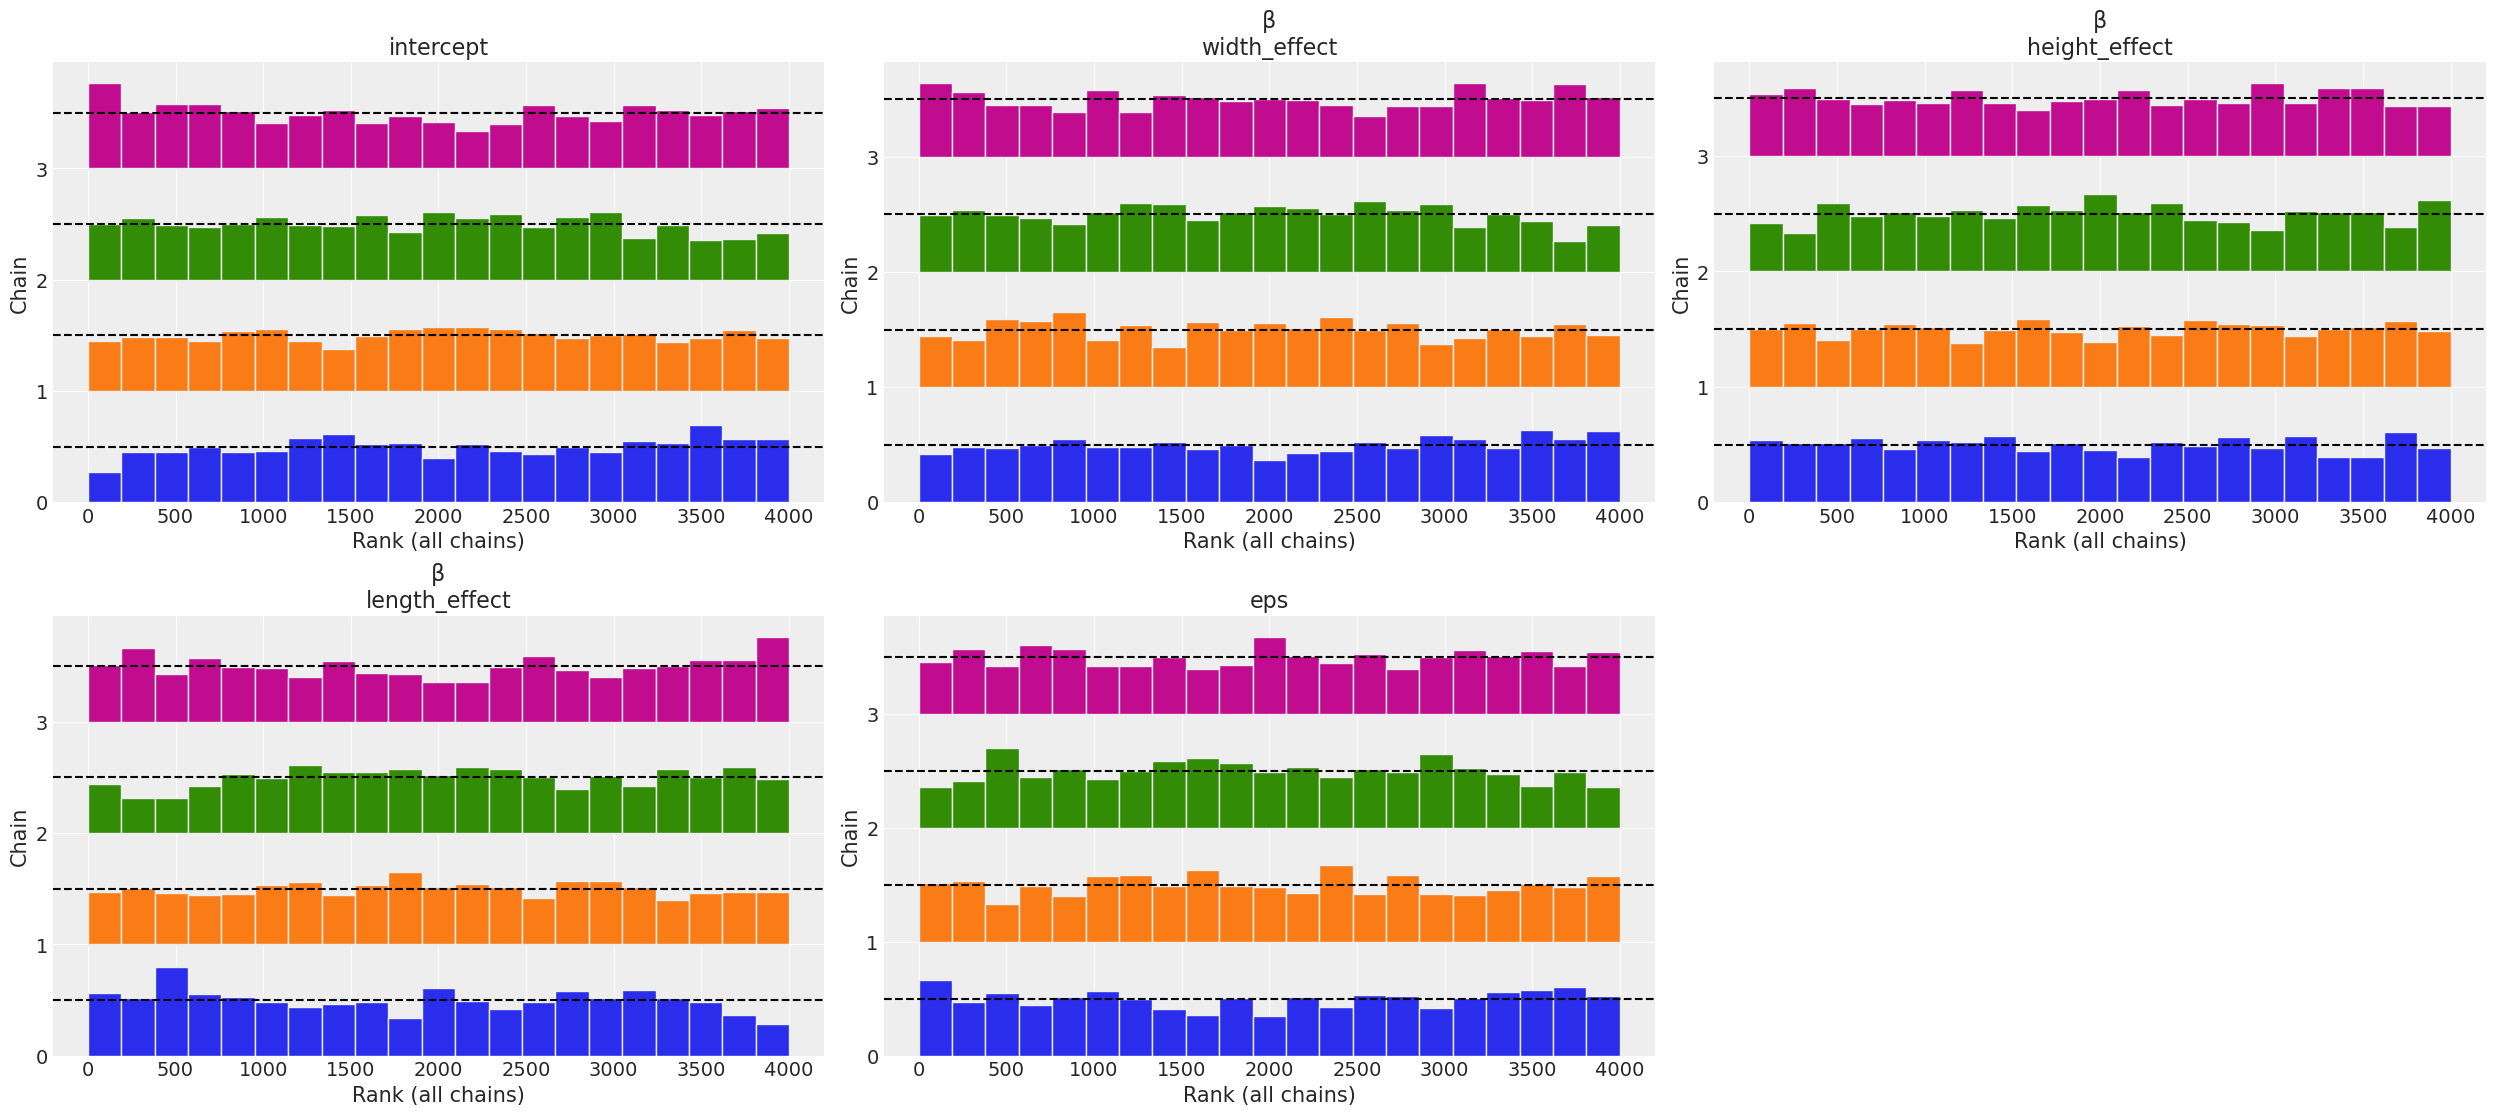

In [9]:
az.plot_rank(idata_simple);

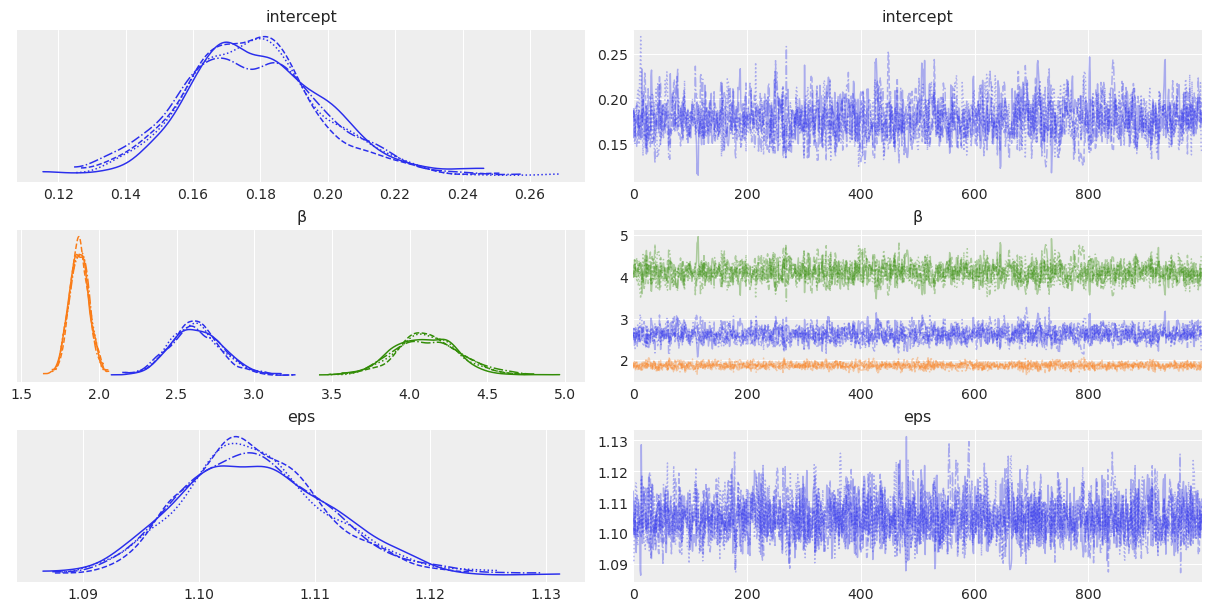

In [10]:
az.plot_trace(idata_simple, transform=np.exp);

/home/oriol/bin/miniforge3/envs/intuitive_bayes/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/oriol/bin/miniforge3/envs/intuitive_bayes/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


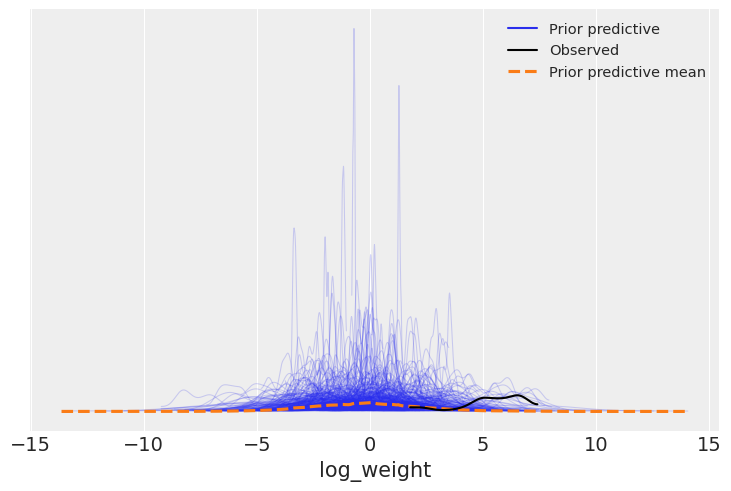

In [11]:
ax = az.plot_ppc(idata_simple, group="prior", observed=True)
ax.set_xlabel("log_weight");